In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='5'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=3,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split3/",
    project_name="breakfast-split-3",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 3, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split3/', 'project_name': 'breakfast-split-3', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split3.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split3.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_split':

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1279
Number of videos not found in train fold is 0
Number of videos logged in test fold is 433
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = np.load("/home/dipika16/ar/TimestampActionSeg/data/breakfast_annotation_all.npy", allow_pickle=True).item()
# loaded_vidid_selected_frames
video_id_boundary_frames = pickle.load(open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [11]:
loaded_mean_var_actions = pickle.load(open("dump_dir/mean_var_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[cur_class]
    mean_class = mean_class * 10
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [12]:
prob_video_each_segment_dict = {}

In [13]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[cur_ele]
        label_next_ele = labels[next_ele]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele.item())

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [14]:
def calculate_element_probb(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_video = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [15]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames[0]
        if start_ele_idx > 0:
            start_ele_label_idx = labels[selected_frames[0]]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames[:-1]):
            next_ele = selected_frames[i + 1]
            label_cur_ele = labels[cur_ele]
            label_next_ele = labels[next_ele]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = labels[selected_frames[-1]]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames[-1] - 1, :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [39]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames, video_id_boundary_frames
    estimated_boundary_dict = {}
    for ele in video_id_boundary_frames.keys():
        if (ele + ".txt") not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        selected_ele_list = loaded_vidid_selected_frames[ele + ".txt"]
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_ele_list[i], selected_ele_list[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_ele_list[i]) or (estimated_boundary > selected_ele_list[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [42]:

def get_boundary_err():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        if (ele + ".txt") not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = video_id_boundary_frames[ele][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [43]:
get_boundary_err()

Train Boundary avergage error = 105.584
Train From boundary avergage accuracy = 88.760


In [30]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [31]:
def get_single_random(labels_all, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((labels_all.shape[0], labels_all.shape[1]), dtype=torch.long, device=labels_all.device) * (-100)
    for iter_num, labels in enumerate(labels_all):
        cur_vidid = video_ids[iter_num]
        frame_idx_tensor = torch.from_numpy(np.array(loaded_vidid_selected_frames[cur_vidid + ".txt"]))
        boundary_target_tensor[iter_num, frame_idx_tensor] = labels[frame_idx_tensor]

    return boundary_target_tensor

In [32]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split3/'

In [44]:
initialize_epoch = 15
expectation_cal_gap = 5
best_val_acc = 0
for epoch in range(15, 1000):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        boundary_target_tensor = get_single_random(item_2, item[4])
        
        loss = 0
        for p in predictions:
            if epoch <= initialize_epoch:
                loss += ce_criterion(p, boundary_target_tensor)
                loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                    F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                            max=16) * src_mask_mse[:, :, 1:])
            else:
                prob = torch.softmax(p, dim=1)
                prob = prob.permute(0, 2, 1)
                es_loss, _ = get_estimated_loss(prob, item_1, item[4], item_2)
                loss += es_loss
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")
    if epoch == initialize_epoch:
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-initial-15-epochs.wt")
    # Calculating Expectation Step
    model.eval()
    if (epoch >= initialize_epoch) and (epoch % expectation_cal_gap == 0):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                prob = torch.softmax(predictions[-1], dim=1)
                prob = prob.permute(0, 2, 1)
                calculate_element_probb(prob, item_1, item[4], item_2)
                
                if i % 10 == 0:
#                     pred = torch.argmax(prob, dim=2)
#                     correct += float(torch.sum((pred == item_2) * src_mask).item())
#                     total += float(torch.sum(src_mask).item())
                    print(f"Epoch {epoch} iter {i}")
                    
#         print(f"Epoch {epoch} After Expectation}, train acc. {correct * 100.0 / total: .3f}")
        get_boundary_err()

    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())
    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-best-model.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-last-model.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Starting Training
Training:: Epoch 15, Iteration 0, Current loss 1.739311933517456 Accuracy 77.92345228996413
Training:: Epoch 15, Iteration 10, Current loss 1.9804925918579102 Accuracy 70.96092925026399
Training:: Epoch 15, Iteration 20, Current loss 2.067516803741455 Accuracy 63.32023575638507
Training:: Epoch 15, Iteration 30, Current loss 1.3061540126800537 Accuracy 63.40113205199975
Training:: Epoch 15, Iteration 40, Current loss 1.5165441036224365 Accuracy 77.19906951070458
Training:: Epoch 15, Iteration 50, Current loss 1.469496488571167 Accuracy 67.29394053443734
Training:: Epoch 15, Iteration 60, Current loss 1.8162904977798462 Accuracy 61.60199867434865
Training:: Epoch 15, Iteration 70, Current loss 1.3940218687057495 Accuracy 79.98275968228558
Training:: Epoch 15, Iteration 80, Current loss 1.8286348581314087 Accuracy 76.96798321627291
Training:: Epoch 15, Iteration 90, Current loss 2.0181009769439697 Accuracy 60.75115965883585
Training:: Epoch 15, Iteration 100, Current lo

Training:: Epoch 19, Iteration 150, Current loss 1.9172805700389697 Accuracy 86.24000830478563
Calculating Validation Data Accuracy
Validation:: Epoch 19, Probability Accuracy 67.6677027471945
Starting Training
Training:: Epoch 20, Iteration 0, Current loss 1.6582796789482426 Accuracy 81.71366000547495
Training:: Epoch 20, Iteration 10, Current loss 1.575872887458479 Accuracy 83.90268184929376
Training:: Epoch 20, Iteration 20, Current loss 4.482389815483668 Accuracy 61.92864307207336
Training:: Epoch 20, Iteration 30, Current loss 2.093778679542371 Accuracy 80.27357192016518
Training:: Epoch 20, Iteration 40, Current loss 1.944051364883151 Accuracy 80.58397803843275
Training:: Epoch 20, Iteration 50, Current loss 1.4229516875685326 Accuracy 89.6528544677582
Training:: Epoch 20, Iteration 60, Current loss 2.2748619353117703 Accuracy 81.55169667038395
Training:: Epoch 20, Iteration 70, Current loss 1.1038623798885925 Accuracy 89.04432231817857
Training:: Epoch 20, Iteration 80, Current 

Training:: Epoch 24, Iteration 150, Current loss 2.073645751890206 Accuracy 84.14868834194267
Calculating Validation Data Accuracy
Validation:: Epoch 24, Probability Accuracy 68.9105529545036
Starting Training
Training:: Epoch 25, Iteration 0, Current loss 1.1966530653073228 Accuracy 85.35743148923665
Training:: Epoch 25, Iteration 10, Current loss 1.4849858305949606 Accuracy 80.64786665268896
Training:: Epoch 25, Iteration 20, Current loss 1.4104912013223676 Accuracy 84.14140642895319
Training:: Epoch 25, Iteration 30, Current loss 1.0315230646762241 Accuracy 87.95499220497526
Training:: Epoch 25, Iteration 40, Current loss 0.9374681979238408 Accuracy 87.88121561715538
Training:: Epoch 25, Iteration 50, Current loss 1.1001319608365234 Accuracy 85.58354133575372
Training:: Epoch 25, Iteration 60, Current loss 0.857439972648002 Accuracy 81.80738982044814
Training:: Epoch 25, Iteration 70, Current loss 1.2159011606831849 Accuracy 88.47709868516111
Training:: Epoch 25, Iteration 80, Curre

Training:: Epoch 29, Iteration 120, Current loss 1.0894625555596031 Accuracy 85.41013211671894
Training:: Epoch 29, Iteration 130, Current loss 0.9489696786533721 Accuracy 85.30281799782033
Training:: Epoch 29, Iteration 140, Current loss 1.5056195625774311 Accuracy 83.8748984565394
Training:: Epoch 29, Iteration 150, Current loss 1.1137738814331566 Accuracy 88.26563164610803
Calculating Validation Data Accuracy
Validation:: Epoch 29, Probability Accuracy 67.65598406258894
Starting Training
Training:: Epoch 30, Iteration 0, Current loss 0.8532115660969799 Accuracy 85.93959731543625
Training:: Epoch 30, Iteration 10, Current loss 1.1851605258269826 Accuracy 85.09999515761949
Training:: Epoch 30, Iteration 20, Current loss 0.9900823794355056 Accuracy 86.25807826148711
Training:: Epoch 30, Iteration 30, Current loss 0.8541820732816224 Accuracy 89.22718233559624
Training:: Epoch 30, Iteration 40, Current loss 1.1378353673330885 Accuracy 86.84118825681679
Training:: Epoch 30, Iteration 50, 

Training:: Epoch 34, Iteration 90, Current loss 0.8769996571842125 Accuracy 85.41378173425652
Training:: Epoch 34, Iteration 100, Current loss 0.4953012704935208 Accuracy 75.88039046089213
Training:: Epoch 34, Iteration 110, Current loss 0.579196436645447 Accuracy 87.32405259087393
Training:: Epoch 34, Iteration 120, Current loss 0.7141961129188243 Accuracy 85.00243664717348
Training:: Epoch 34, Iteration 130, Current loss 0.6681475224179354 Accuracy 87.28448275862068
Training:: Epoch 34, Iteration 140, Current loss 0.5490142358706984 Accuracy 90.2105734767025
Training:: Epoch 34, Iteration 150, Current loss 0.8033547502278438 Accuracy 83.57330363535121
Calculating Validation Data Accuracy
Validation:: Epoch 34, Probability Accuracy 69.59693305282894
Starting Training
Training:: Epoch 35, Iteration 0, Current loss 0.46093596568663286 Accuracy 90.38353073886069
Training:: Epoch 35, Iteration 10, Current loss 0.9963554170838094 Accuracy 89.06435057244374
Training:: Epoch 35, Iteration 20

Training:: Epoch 39, Iteration 60, Current loss 0.5941040145906463 Accuracy 82.8921655711494
Training:: Epoch 39, Iteration 70, Current loss 0.6630801112090036 Accuracy 94.57524140175762
Training:: Epoch 39, Iteration 80, Current loss 0.821842517639522 Accuracy 91.23213595983005
Training:: Epoch 39, Iteration 90, Current loss 0.7725815850880525 Accuracy 83.10423304506145
Training:: Epoch 39, Iteration 100, Current loss 0.8616609238154079 Accuracy 86.91983122362869
Training:: Epoch 39, Iteration 110, Current loss 0.6254946963143027 Accuracy 90.52502729347934
Training:: Epoch 39, Iteration 120, Current loss 0.8932337467290425 Accuracy 79.49219874489032
Training:: Epoch 39, Iteration 130, Current loss 0.6836323433496566 Accuracy 86.16686557448193
Training:: Epoch 39, Iteration 140, Current loss 1.061463959188944 Accuracy 85.62934967967922
Training:: Epoch 39, Iteration 150, Current loss 1.5679888314153028 Accuracy 83.00643339086773
Calculating Validation Data Accuracy
Validation:: Epoch 3

Training:: Epoch 44, Iteration 30, Current loss 0.6260113199950795 Accuracy 89.52026082906382
Training:: Epoch 44, Iteration 40, Current loss 0.4025550130564303 Accuracy 94.08173493097635
Training:: Epoch 44, Iteration 50, Current loss 0.5682261443371323 Accuracy 89.41972381085228
Training:: Epoch 44, Iteration 60, Current loss 0.43015562992324996 Accuracy 90.54103790945896
Training:: Epoch 44, Iteration 70, Current loss 0.6174440865411133 Accuracy 89.3114406779661
Training:: Epoch 44, Iteration 80, Current loss 0.4273712807252706 Accuracy 91.38361638361638
Training:: Epoch 44, Iteration 90, Current loss 0.4642264706502186 Accuracy 88.96813267674194
Training:: Epoch 44, Iteration 100, Current loss 0.4769049560175943 Accuracy 90.92880486240493
Training:: Epoch 44, Iteration 110, Current loss 0.7175209116206966 Accuracy 88.7930055637561
Training:: Epoch 44, Iteration 120, Current loss 0.44959738769389307 Accuracy 88.89715090795241
Training:: Epoch 44, Iteration 130, Current loss 0.589826

Training:: Epoch 49, Iteration 0, Current loss 0.3430966510437109 Accuracy 85.60005762858378
Training:: Epoch 49, Iteration 10, Current loss 0.32099189427204144 Accuracy 91.75989882284269
Training:: Epoch 49, Iteration 20, Current loss 0.3717568990568056 Accuracy 90.29338516673754
Training:: Epoch 49, Iteration 30, Current loss 0.3925410393947496 Accuracy 90.22090169228782
Training:: Epoch 49, Iteration 40, Current loss 0.3044436936515229 Accuracy 87.5798650504568
Training:: Epoch 49, Iteration 50, Current loss 0.3384213287901165 Accuracy 90.04747518342684
Training:: Epoch 49, Iteration 60, Current loss 0.3186977755464281 Accuracy 92.64058476617659
Training:: Epoch 49, Iteration 70, Current loss 0.42345676793213033 Accuracy 89.64037012305637
Training:: Epoch 49, Iteration 80, Current loss 0.46738948389456164 Accuracy 89.33350164099974
Training:: Epoch 49, Iteration 90, Current loss 0.3185897753341247 Accuracy 91.34028027308659
Training:: Epoch 49, Iteration 100, Current loss 0.30120994

Training:: Epoch 53, Iteration 140, Current loss 2.8617145685747545 Accuracy 73.21710318712528
Training:: Epoch 53, Iteration 150, Current loss 2.269406848281786 Accuracy 81.60071942446044
Calculating Validation Data Accuracy
Validation:: Epoch 53, Probability Accuracy 65.95543551654288
Starting Training
Training:: Epoch 54, Iteration 0, Current loss 0.8501961624028086 Accuracy 83.05317512634586
Training:: Epoch 54, Iteration 10, Current loss 1.4186353484012635 Accuracy 83.42310306960205
Training:: Epoch 54, Iteration 20, Current loss 1.3842017155696462 Accuracy 82.53674812877627
Training:: Epoch 54, Iteration 30, Current loss 1.771448031144173 Accuracy 81.62435983077266
Training:: Epoch 54, Iteration 40, Current loss 1.5454037368557851 Accuracy 84.68072921637874
Training:: Epoch 54, Iteration 50, Current loss 1.2774369311385918 Accuracy 82.77624390530458
Training:: Epoch 54, Iteration 60, Current loss 1.5617137154224532 Accuracy 80.99370427088651
Training:: Epoch 54, Iteration 70, Cur

Training:: Epoch 58, Iteration 110, Current loss 0.396274595675183 Accuracy 87.51559251559252
Training:: Epoch 58, Iteration 120, Current loss 0.3547026184906913 Accuracy 89.8051282051282
Training:: Epoch 58, Iteration 130, Current loss 0.29641228583884005 Accuracy 87.29513987001978
Training:: Epoch 58, Iteration 140, Current loss 0.3078593841316219 Accuracy 86.34297833661566
Training:: Epoch 58, Iteration 150, Current loss 0.3247105506035527 Accuracy 89.86245542536933
Calculating Validation Data Accuracy
Validation:: Epoch 58, Probability Accuracy 70.99770648601292
Starting Training
Training:: Epoch 59, Iteration 0, Current loss 0.3205933587432677 Accuracy 83.24198250728863
Training:: Epoch 59, Iteration 10, Current loss 0.3264130481014301 Accuracy 93.55982465188241
Training:: Epoch 59, Iteration 20, Current loss 0.3254342374624605 Accuracy 83.18823757012962
Training:: Epoch 59, Iteration 30, Current loss 0.38935231838260537 Accuracy 89.09265920259385
Training:: Epoch 59, Iteration 40

Training:: Epoch 63, Iteration 80, Current loss 0.3546572975380524 Accuracy 88.82940240196788
Training:: Epoch 63, Iteration 90, Current loss 0.26620173444996753 Accuracy 71.77514382754558
Training:: Epoch 63, Iteration 100, Current loss 0.3430187120307773 Accuracy 87.70242914979757
Training:: Epoch 63, Iteration 110, Current loss 0.4812592385743737 Accuracy 86.74033149171271
Training:: Epoch 63, Iteration 120, Current loss 0.2599361842835155 Accuracy 91.67492566897918
Training:: Epoch 63, Iteration 130, Current loss 0.2930186125951291 Accuracy 89.27547314089084
Training:: Epoch 63, Iteration 140, Current loss 0.2559941554893771 Accuracy 90.29032735890979
Training:: Epoch 63, Iteration 150, Current loss 0.3417904173280929 Accuracy 88.65583938627275
Calculating Validation Data Accuracy
Validation:: Epoch 63, Probability Accuracy 70.12226494271795
Starting Training
Training:: Epoch 64, Iteration 0, Current loss 0.22337694933519228 Accuracy 90.64089126974885
Training:: Epoch 64, Iteration

Training:: Epoch 68, Iteration 50, Current loss 1.21734885028795 Accuracy 84.66012542990087
Training:: Epoch 68, Iteration 60, Current loss 1.453906178256922 Accuracy 83.84207424867414
Training:: Epoch 68, Iteration 70, Current loss 0.6769170484979425 Accuracy 87.59341267644616
Training:: Epoch 68, Iteration 80, Current loss 0.7703497843281049 Accuracy 88.1555104057987
Training:: Epoch 68, Iteration 90, Current loss 0.6916404150462527 Accuracy 83.81714649782981
Training:: Epoch 68, Iteration 100, Current loss 1.2890359619639917 Accuracy 80.73142285904699
Training:: Epoch 68, Iteration 110, Current loss 1.8397302921216263 Accuracy 83.49114331723027
Training:: Epoch 68, Iteration 120, Current loss 1.0183785256147793 Accuracy 81.53363304775638
Training:: Epoch 68, Iteration 130, Current loss 1.2673310290034168 Accuracy 83.26612903225806
Training:: Epoch 68, Iteration 140, Current loss 0.889184958714668 Accuracy 91.22456529781724
Training:: Epoch 68, Iteration 150, Current loss 0.685450805

Training:: Epoch 73, Iteration 20, Current loss 0.25029487230226133 Accuracy 90.31296572280179
Training:: Epoch 73, Iteration 30, Current loss 0.2374917098844282 Accuracy 89.58108836206897
Training:: Epoch 73, Iteration 40, Current loss 0.35008125666366513 Accuracy 87.06355701036551
Training:: Epoch 73, Iteration 50, Current loss 0.30064650660227277 Accuracy 89.17880698702616
Training:: Epoch 73, Iteration 60, Current loss 0.3607264700458399 Accuracy 81.50885372749367
Training:: Epoch 73, Iteration 70, Current loss 0.19757363828572522 Accuracy 93.56097961867192
Training:: Epoch 73, Iteration 80, Current loss 0.3470398976499126 Accuracy 88.43531653609993
Training:: Epoch 73, Iteration 90, Current loss 0.33891828193388074 Accuracy 89.6095409246855
Training:: Epoch 73, Iteration 100, Current loss 0.1862411101901788 Accuracy 92.1571584781871
Training:: Epoch 73, Iteration 110, Current loss 0.2858925349011372 Accuracy 89.63565617262115
Training:: Epoch 73, Iteration 120, Current loss 0.2902

Calculating Validation Data Accuracy
Validation:: Epoch 77, Probability Accuracy 68.23310137778249
Starting Training
Training:: Epoch 78, Iteration 0, Current loss 0.32474709185043765 Accuracy 83.77417060078898
Training:: Epoch 78, Iteration 10, Current loss 0.3893854872713797 Accuracy 87.11025393764064
Training:: Epoch 78, Iteration 20, Current loss 0.2940789066540651 Accuracy 85.59772643931059
Training:: Epoch 78, Iteration 30, Current loss 0.35441780316587995 Accuracy 87.03703703703704
Training:: Epoch 78, Iteration 40, Current loss 0.22829584951933715 Accuracy 86.60778845160624
Training:: Epoch 78, Iteration 50, Current loss 0.32905499708789815 Accuracy 84.8186794389326
Training:: Epoch 78, Iteration 60, Current loss 0.321469380335497 Accuracy 86.02363286617202
Training:: Epoch 78, Iteration 70, Current loss 0.3402457434211712 Accuracy 88.44551927986028
Training:: Epoch 78, Iteration 80, Current loss 0.3437190554733634 Accuracy 81.51432920775697
Training:: Epoch 78, Iteration 90, C

Training:: Epoch 82, Iteration 130, Current loss 0.7222092311287425 Accuracy 78.37856312803336
Training:: Epoch 82, Iteration 140, Current loss 1.059534601916567 Accuracy 89.0793232256647
Training:: Epoch 82, Iteration 150, Current loss 0.7121267504733277 Accuracy 87.0041187947106
Calculating Validation Data Accuracy
Validation:: Epoch 82, Probability Accuracy 68.54883622301215
Starting Training
Training:: Epoch 83, Iteration 0, Current loss 0.4837715323237375 Accuracy 87.35249042145594
Training:: Epoch 83, Iteration 10, Current loss 0.4483520642811675 Accuracy 89.15127726658517
Training:: Epoch 83, Iteration 20, Current loss 0.48114899111351056 Accuracy 82.18974222694659
Training:: Epoch 83, Iteration 30, Current loss 0.35478713548656216 Accuracy 84.76457463241604
Training:: Epoch 83, Iteration 40, Current loss 0.49268086011987505 Accuracy 86.47058823529412
Training:: Epoch 83, Iteration 50, Current loss 0.3784281246055424 Accuracy 89.18159236501504
Training:: Epoch 83, Iteration 60, 

Training:: Epoch 87, Iteration 100, Current loss 0.6376789806298289 Accuracy 84.85320862561704
Training:: Epoch 87, Iteration 110, Current loss 0.582098515352846 Accuracy 79.98492628008856
Training:: Epoch 87, Iteration 120, Current loss 0.47828705451393383 Accuracy 89.95684044666713
Training:: Epoch 87, Iteration 130, Current loss 0.34590366281472823 Accuracy 91.45236855804269
Training:: Epoch 87, Iteration 140, Current loss 0.7781249681149293 Accuracy 76.46071345301935
Training:: Epoch 87, Iteration 150, Current loss 0.4629686284618859 Accuracy 81.75744536292605
Calculating Validation Data Accuracy
Validation:: Epoch 87, Probability Accuracy 69.8512843120295
Starting Training
Training:: Epoch 88, Iteration 0, Current loss 0.360887423208672 Accuracy 85.23446658851114
Training:: Epoch 88, Iteration 10, Current loss 0.37640106152101427 Accuracy 88.67966723320512
Training:: Epoch 88, Iteration 20, Current loss 0.48628494984209614 Accuracy 87.5057348218382
Training:: Epoch 88, Iteration 3

Training:: Epoch 92, Iteration 70, Current loss 0.298840816914285 Accuracy 81.24718932693749
Training:: Epoch 92, Iteration 80, Current loss 0.23195890042385953 Accuracy 88.68007232480412
Training:: Epoch 92, Iteration 90, Current loss 0.22655158542521814 Accuracy 91.38502319416833
Training:: Epoch 92, Iteration 100, Current loss 0.31768234676528984 Accuracy 86.1317100166021
Training:: Epoch 92, Iteration 110, Current loss 0.2799369393194526 Accuracy 84.76656439174062
Training:: Epoch 92, Iteration 120, Current loss 0.19574841360989584 Accuracy 85.0445717924228
Training:: Epoch 92, Iteration 130, Current loss 0.31907132182010733 Accuracy 82.46563931695127
Training:: Epoch 92, Iteration 140, Current loss 0.32574741835372745 Accuracy 88.33834992668056
Training:: Epoch 92, Iteration 150, Current loss 0.3577308456267755 Accuracy 84.81336287710926
Calculating Validation Data Accuracy
Validation:: Epoch 92, Probability Accuracy 69.9896763968951
Starting Training
Training:: Epoch 93, Iteratio

Training:: Epoch 97, Iteration 40, Current loss 0.22814961414160018 Accuracy 86.15058324496289
Training:: Epoch 97, Iteration 50, Current loss 0.3263257063244444 Accuracy 82.9226431286012
Training:: Epoch 97, Iteration 60, Current loss 0.24396088203828897 Accuracy 84.41743086656714
Training:: Epoch 97, Iteration 70, Current loss 0.22085486644844576 Accuracy 82.02174788562223
Training:: Epoch 97, Iteration 80, Current loss 0.23078766023321165 Accuracy 88.33208302075519
Training:: Epoch 97, Iteration 90, Current loss 0.2306113312257225 Accuracy 89.9465093951447
Training:: Epoch 97, Iteration 100, Current loss 0.5433882041545253 Accuracy 79.02846389084921
Training:: Epoch 97, Iteration 110, Current loss 0.24408744122297224 Accuracy 88.94368170355843
Training:: Epoch 97, Iteration 120, Current loss 0.4020965428712281 Accuracy 87.43840438013297
Training:: Epoch 97, Iteration 130, Current loss 0.26213124509425995 Accuracy 89.35575556608242
Training:: Epoch 97, Iteration 140, Current loss 0.2

Training:: Epoch 102, Iteration 0, Current loss 0.3177907557146252 Accuracy 86.00267891312667
Training:: Epoch 102, Iteration 10, Current loss 0.2660973645735235 Accuracy 82.63384005287509
Training:: Epoch 102, Iteration 20, Current loss 0.41947640149538806 Accuracy 86.32923954844313
Training:: Epoch 102, Iteration 30, Current loss 0.21162231018324923 Accuracy 89.71903863823202
Training:: Epoch 102, Iteration 40, Current loss 0.23765063570882686 Accuracy 87.49656499038197
Training:: Epoch 102, Iteration 50, Current loss 0.2520681476352024 Accuracy 89.19210053859965
Training:: Epoch 102, Iteration 60, Current loss 0.232453817292341 Accuracy 89.90585774058577
Training:: Epoch 102, Iteration 70, Current loss 0.22747213192496124 Accuracy 87.22054535222796
Training:: Epoch 102, Iteration 80, Current loss 0.2172201842281882 Accuracy 87.1563425894026
Training:: Epoch 102, Iteration 90, Current loss 0.330595685917359 Accuracy 85.19652565144035
Training:: Epoch 102, Iteration 100, Current loss 

Training:: Epoch 106, Iteration 130, Current loss 0.2613301306588092 Accuracy 85.93120128997582
Training:: Epoch 106, Iteration 140, Current loss 0.21777245826005642 Accuracy 88.61648890461507
Training:: Epoch 106, Iteration 150, Current loss 0.21354171749863046 Accuracy 87.7673051586095
Calculating Validation Data Accuracy
Validation:: Epoch 106, Probability Accuracy 70.27750961211154
Starting Training
Training:: Epoch 107, Iteration 0, Current loss 0.200488073836741 Accuracy 89.13959978623598
Training:: Epoch 107, Iteration 10, Current loss 0.20804323760918703 Accuracy 84.11965811965813
Training:: Epoch 107, Iteration 20, Current loss 0.23598854346350362 Accuracy 91.1188369152971
Training:: Epoch 107, Iteration 30, Current loss 0.2191636101072333 Accuracy 85.00958689210388
Training:: Epoch 107, Iteration 40, Current loss 0.15538033361619813 Accuracy 89.00225772837791
Training:: Epoch 107, Iteration 50, Current loss 0.13373628363793533 Accuracy 88.722512193035
Training:: Epoch 107, It

Training:: Epoch 111, Iteration 90, Current loss 0.23370487594213854 Accuracy 86.14720864954776
Training:: Epoch 111, Iteration 100, Current loss 0.21590076066503058 Accuracy 87.57079760976877
Training:: Epoch 111, Iteration 110, Current loss 0.18773457126442863 Accuracy 88.24279711884753
Training:: Epoch 111, Iteration 120, Current loss 0.23101083818721196 Accuracy 86.47116934435606
Training:: Epoch 111, Iteration 130, Current loss 0.3655477366504754 Accuracy 82.17255717255718
Training:: Epoch 111, Iteration 140, Current loss 0.20563592049703036 Accuracy 86.06878537222464
Training:: Epoch 111, Iteration 150, Current loss 0.2074083541204913 Accuracy 87.16512702078522
Calculating Validation Data Accuracy
Validation:: Epoch 111, Probability Accuracy 69.08488233882623
Starting Training
Training:: Epoch 112, Iteration 0, Current loss 0.1671624288681774 Accuracy 89.62967896629812
Training:: Epoch 112, Iteration 10, Current loss 0.3760179152128812 Accuracy 77.79954293176624
Training:: Epoch 

Training:: Epoch 116, Iteration 50, Current loss 0.20973531369795823 Accuracy 82.7944111776447
Training:: Epoch 116, Iteration 60, Current loss 0.212663410802047 Accuracy 91.36096845194425
Training:: Epoch 116, Iteration 70, Current loss 0.279393541151358 Accuracy 81.67747432195769
Training:: Epoch 116, Iteration 80, Current loss 0.2106181314648345 Accuracy 87.33845512476923
Training:: Epoch 116, Iteration 90, Current loss 0.24478807120453472 Accuracy 77.39415818838202
Training:: Epoch 116, Iteration 100, Current loss 0.2314285300715253 Accuracy 89.16906327033689
Training:: Epoch 116, Iteration 110, Current loss 0.26492841243147974 Accuracy 86.35365011612579
Training:: Epoch 116, Iteration 120, Current loss 0.2006192567736638 Accuracy 91.46134527930496
Training:: Epoch 116, Iteration 130, Current loss 0.22029117094106432 Accuracy 85.68151697420736
Training:: Epoch 116, Iteration 140, Current loss 0.23429164592084187 Accuracy 89.31880108991825
Training:: Epoch 116, Iteration 150, Curren

Training:: Epoch 121, Iteration 10, Current loss 0.1741438091507269 Accuracy 86.21556509898397
Training:: Epoch 121, Iteration 20, Current loss 0.1353752294167687 Accuracy 88.01010617884099
Training:: Epoch 121, Iteration 30, Current loss 0.32092804017341714 Accuracy 77.02020202020202
Training:: Epoch 121, Iteration 40, Current loss 0.22465338533456616 Accuracy 86.18380541871922
Training:: Epoch 121, Iteration 50, Current loss 0.16612487643704568 Accuracy 88.12405446293495
Training:: Epoch 121, Iteration 60, Current loss 0.35832498853335476 Accuracy 84.24806201550388
Training:: Epoch 121, Iteration 70, Current loss 0.21384798046599984 Accuracy 91.16065426842931
Training:: Epoch 121, Iteration 80, Current loss 0.23831464032639138 Accuracy 89.9848858483812
Training:: Epoch 121, Iteration 90, Current loss 0.28762403194903685 Accuracy 87.712185101092
Training:: Epoch 121, Iteration 100, Current loss 0.21564937055257155 Accuracy 92.8217994285316
Training:: Epoch 121, Iteration 110, Current 

KeyboardInterrupt: 

In [24]:
!ls '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split3/ms-tcn-initial-15-epochs.wt'


/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split3/ms-tcn-initial-15-epochs.wt


In [24]:
torch.save(model.state_dict(),
"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/final-em-maximized.wt")

In [34]:
model.load_state_dict(torch.load(f"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split3/ms-tcn-initial-15-epochs.wt"))

<All keys matched successfully>

In [25]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Epoch {epoch}, Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Epoch 15, Probability Accuracy 57.770101729343025


In [ ]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [4]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [6]:
import glob
import numpy as np
boundary_dict = {}
for file in glob.glob("/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/*txt"):
    video_id = file.split("/")[-1].split(".txt")[0]
    data = open(file).read().split("\n")[0:-1]
    data = np.array(data)
    boundary = get_boundary(data)
    boundary_dict[video_id] = boundary
    

In [ ]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

In [29]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[4]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [34]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele + ".txt"]):
        print(ele)

In [9]:
import pickle
# pickle.dump(video_id_boundary_frames, open("dump_dir/video_id_boundary_frames_dict.pkl", "wb"))
# pickle.dump(loaded_vidid_selected_frames, open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "wb"))
pickle.dump(boundary_dict, open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "wb"))

In [ ]:
def get_ensemble_out(outp):
    
    weights = [1, 1, 1, 1, 0, 0]
    ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

    for i, outp_ele in enumerate(outp[1]):
        upped_logit = F.upsample(outp_ele, size=outp[0].shape[-1], mode='linear', align_corners=True)
        ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i + 1] / sum(weights)
    
    return ensemble_prob

In [ ]:
model.load_state_dict(torch.load('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/split2_c2ftcn_model.wt'))

In [76]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4], item_2)

        if i%10==0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
Train Boundary avergage error = 107.269
Train From boundary avergage accuracy = 87.407


In [77]:
with torch.no_grad():
    idx = 4

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
    
    bound_list = video_id_boundary_frames[cur_vidid]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, item_2[idx])


Min prob 0 = 7.953912266787591e-36
Min prob 1 = 2.7495868628582206e-249
Min prob 2 = 8.185175464823537e-201


(0, 442)

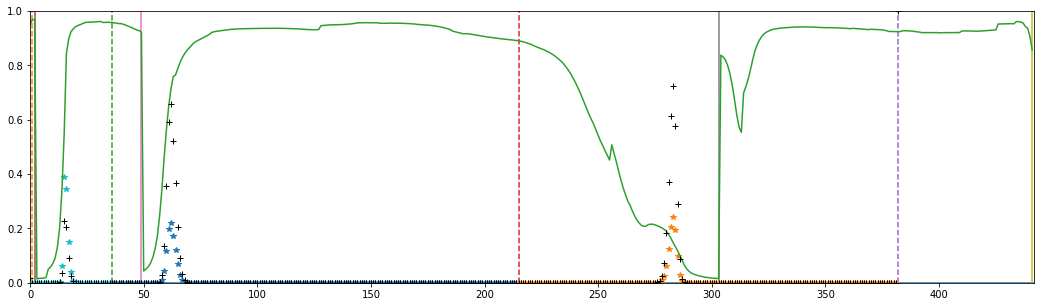

In [78]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid + ".txt"][i], 
                   loaded_vidid_selected_frames[cur_vidid + ".txt"][i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

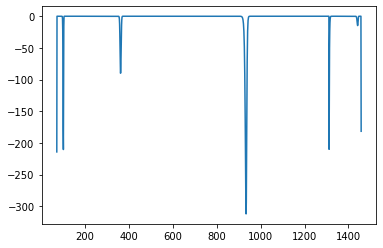

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

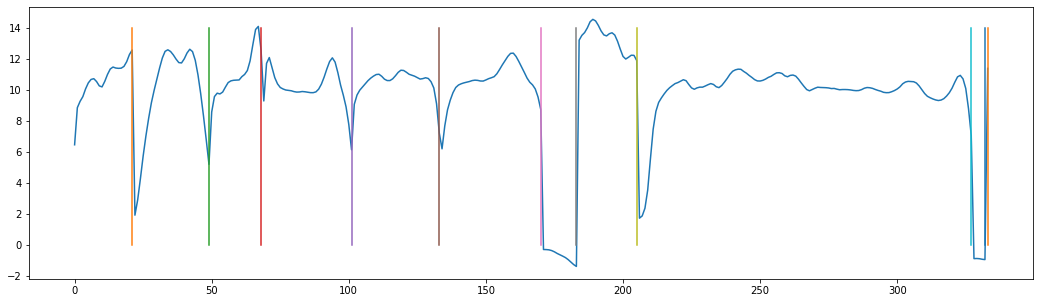

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss